In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, GlobalAveragePooling2D, multiply
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns

# Load the dataset and define paths for training and testing
path_train = 'C:/Users/aasth/Desktop/earlystepping/Brain Tumor MRI Classfication/Training'
path_test = 'C:/Users/aasth/Desktop/earlystepping/Brain Tumor MRI Classfication/Testing'

# Initialize lists to store the image data, paths, and labels
data = []
y = []

# Loop through the directories and files in the training data path
for r, d, f in os.walk(path_train):
    for file in f:
        if '.jpg' in file:
            # If the file is an image file, append its path to the paths_train list
            path = os.path.join(r, file)
            # Use the parent directory to determine the label for the image and append it to the y list
            if 'glioma_tumor' in r:
                y.append(3)
            elif 'meningioma_tumor' in r:
                y.append(2)
            elif 'pituitary_tumor' in r:
                y.append(1)
            elif 'no_tumor' in r:
                y.append(0)
            # Load the image using PIL, resize it to 128x128, and append it to the data list
            img = Image.open(path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(np.array(img))

# Loop through the directories and files in the testing data path
for r, d, f in os.walk(path_test):
    for file in f:
        if '.jpg' in file:
            # If the file is an image file, append its path to the paths_test list
            path = os.path.join(r, file)
            # Use the parent directory to determine the label for the image and append it to the y list
            if 'glioma_tumor' in r:
                y.append(3)
            elif 'meningioma_tumor' in r:
                y.append(2)
            elif 'pituitary_tumor' in r:
                y.append(1)
            elif 'no_tumor' in r:
                y.append(0)
            # Load the image using PIL, resize it to 128x128, and append it to the data list
            img = Image.open(path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(np.array(img))

# Convert y and data to a numpy array and also y to one-hot encoding
y = np.array(y)
le = LabelEncoder()
y = le.fit_transform(y)
y = np_utils.to_categorical(y)

# Normalize the data
data = np.array(data)
data = data.astype('float32')
data /= 255

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, shuffle=True, random_state=42)

# Load the pre-trained InceptionV3 model with weights trained on ImageNet
#base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


# Freeze the initial layers of the base model
# for layer in base_model.layers[:100]:
#     layer.trainable = False
for layer in base_model.layers[:10]:
    layer.trainable = False


# Create a new model by adding your classifier layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))

# Add the attention mechanism
attention_probs = Dense(128, activation='softmax')(model.output)
attention_mul = multiply([model.output, attention_probs])
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Define the learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr = lr * 0.5  # Reduce the learning rate by half every 5 epochs
    return lr

# Define the learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model and save the history
history = model.fit(X_train, y_train, batch_size=50, epochs=15, validation_data=(X_test, y_test),
                    callbacks=[lr_scheduler, early_stopping], verbose=1)



58889256/58889256 [==============================] - 12s 0us/step
Epoch 1/15
53/53 [==============================] - 439s 8s/step - loss: 1.9020 - accuracy: 0.2746 - val_loss: 1.3755 - val_accuracy: 0.2864 - lr: 0.0010
Epoch 2/15
53/53 [==============================] - 444s 8s/step - loss: 1.3721 - accuracy: 0.2830 - val_loss: 1.3634 - val_accuracy: 0.2864 - lr: 0.0010
Epoch 3/15
53/53 [==============================] - 428s 8s/step - loss: 1.3660 - accuracy: 0.2911 - val_loss: 1.3572 - val_accuracy: 0.2864 - lr: 0.0010
Epoch 4/15
53/53 [==============================] - 425s 8s/step - loss: 1.3633 - accuracy: 0.2807 - val_loss: 1.3534 - val_accuracy: 0.2864 - lr: 0.0010
Epoch 5/15
53/53 [==============================] - 455s 9s/step - loss: 1.3628 - accuracy: 0.2788 - val_loss: 1.3519 - val_accuracy: 0.2864 - lr: 0.0010
Epoch 6/15
53/53 [==============================] - 425s 8s/step - loss: 1.3635 - accuracy: 0.2838 - val_loss: 1.3514 - val_accuracy: 0.2864 - lr: 5.0000e-04
Epoch 

In [2]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

21/21 [==============================] - 59s 3s/step - loss: 1.3499 - accuracy: 0.2864
Test loss: 1.3499468564987183
Test accuracy: 0.2863706052303314


21/21 [==============================] - 59s 3s/step


C:\Users\aasth\anaconda3\envs\mricnn\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


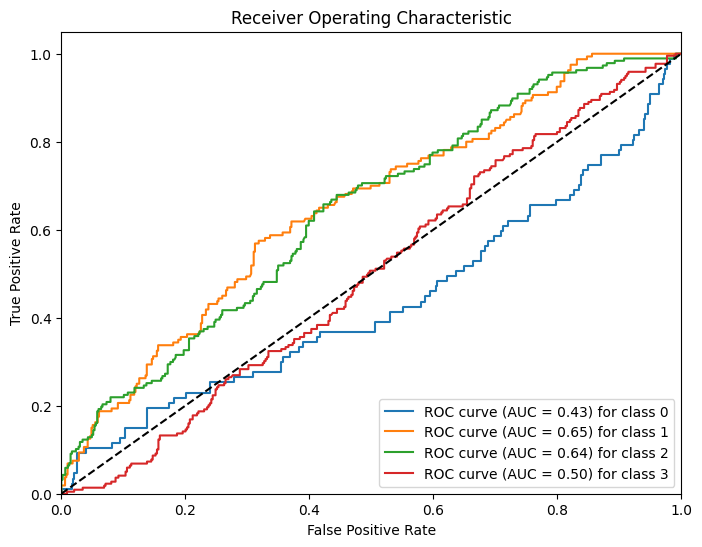

In [3]:
# Evaluation
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate performance metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

# Save performance metrics to CSV
metrics_dict = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])
metrics_df.to_csv('performance_metrics_vgg19.csv')

# Plot and save ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(le.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for class {le.classes_[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('roc_curves_vgg19.png')
plt.show()


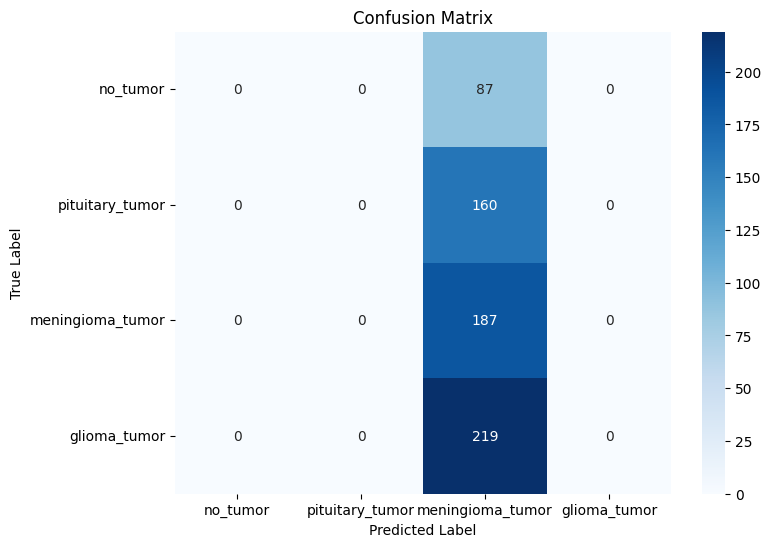

In [4]:
import seaborn as sns

# Map the class labels to tumor type names
class_labels = le.classes_
class_names = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot heatmap confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Save the heatmap as a PNG file
plt.savefig('confusion_matrix_vgg19.png')

# Show the heatmap
plt.show()


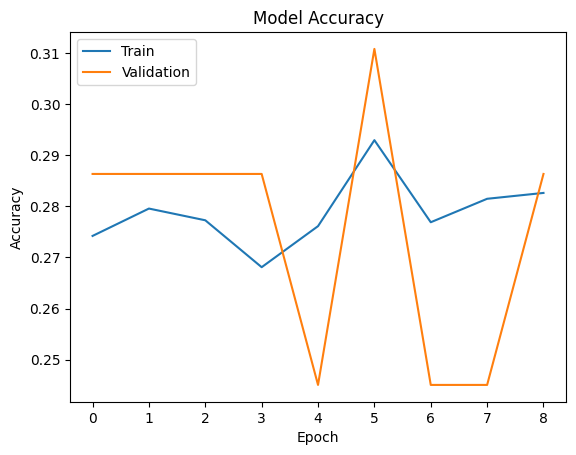

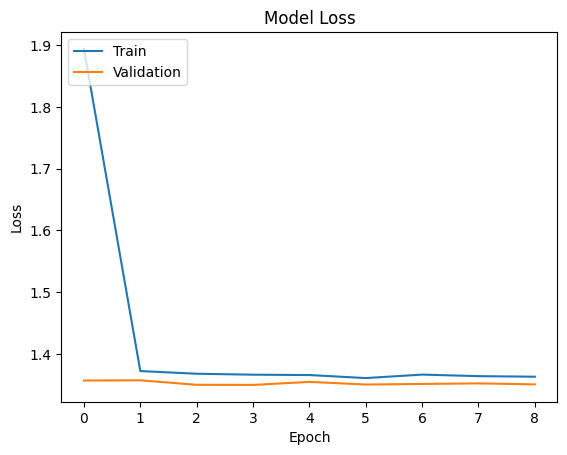

In [5]:
import matplotlib.pyplot as plt
# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()